<a href="https://colab.research.google.com/github/Praneeth-18/Regression-MLP-and-Latent-Manifolds/blob/main/Latent_Classification_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Business Narration:

### Uber is currently just doing cars (back in 2015)
### They decide to start doing bikes and compete with citibike(A leading electric bike player)
### Based on citibike's data we plan to recommend Uber bikes to our customers when a trip customer is trying to take is very similar to citibike's trips.


## Data Preprocessing and Adding Latent Variables to Base Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_clean_preclustering_datetime_split.csv')
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,date,time,day_of_week,haversine_distance_km,year,month,day,hour,minutes,seconds
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,0.015140,2015-05-07,1900-01-01 19:52:06,3,1.683323,2015,5,7,19,52,6
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,0.022103,2009-07-17,1900-01-01 20:04:56,4,2.457590,2009,7,17,20,4,56
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,0.053109,2009-08-24,1900-01-01 21:45:00,0,5.036377,2009,8,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,0.016528,2009-06-26,1900-01-01 08:22:21,4,1.661683,2009,6,26,8,22,21
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,0.051031,2014-08-28,1900-01-01 17:47:00,3,4.475450,2014,8,28,17,47,0


In [ ]:
data['pickup_latitude'].min(), data['pickup_latitude'].max(), data['pickup_longitude'].min(), data['pickup_longitude'].max()

(40.190563553444, 41.366138, -75.426904156772, -73.137393)

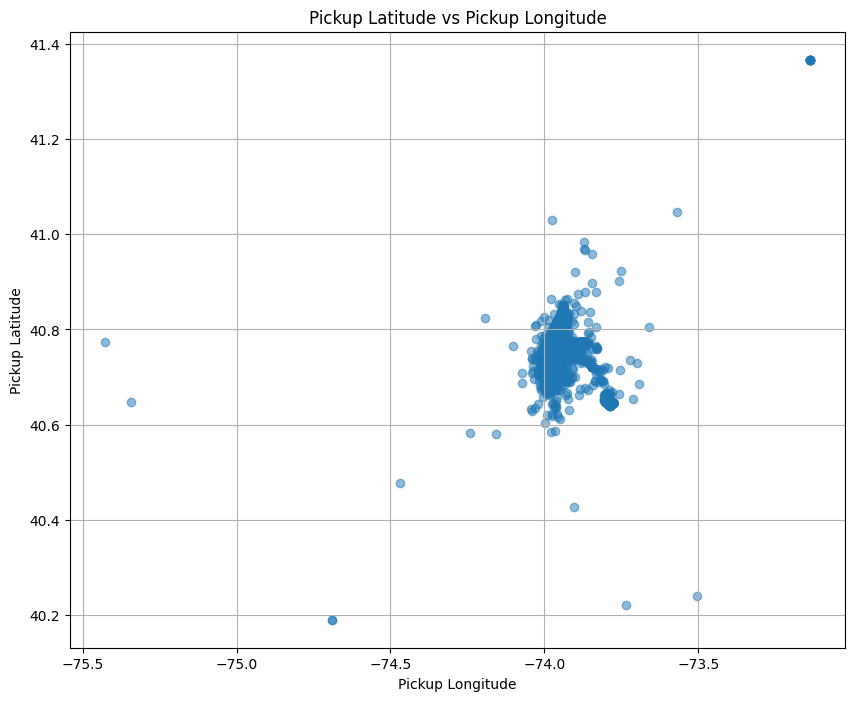

In [ ]:
#used chatgpt
import pandas as pd
import matplotlib.pyplot as plt

# Plotting pickup latitude vs pickup longitude
plt.figure(figsize=(10, 8))
plt.scatter(data['pickup_longitude'], data['pickup_latitude'], alpha=0.5)
plt.title('Pickup Latitude vs Pickup Longitude')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.grid(True)
plt.show()

In [ ]:
!pip install contextily

In [ ]:
#used chatgpt
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt

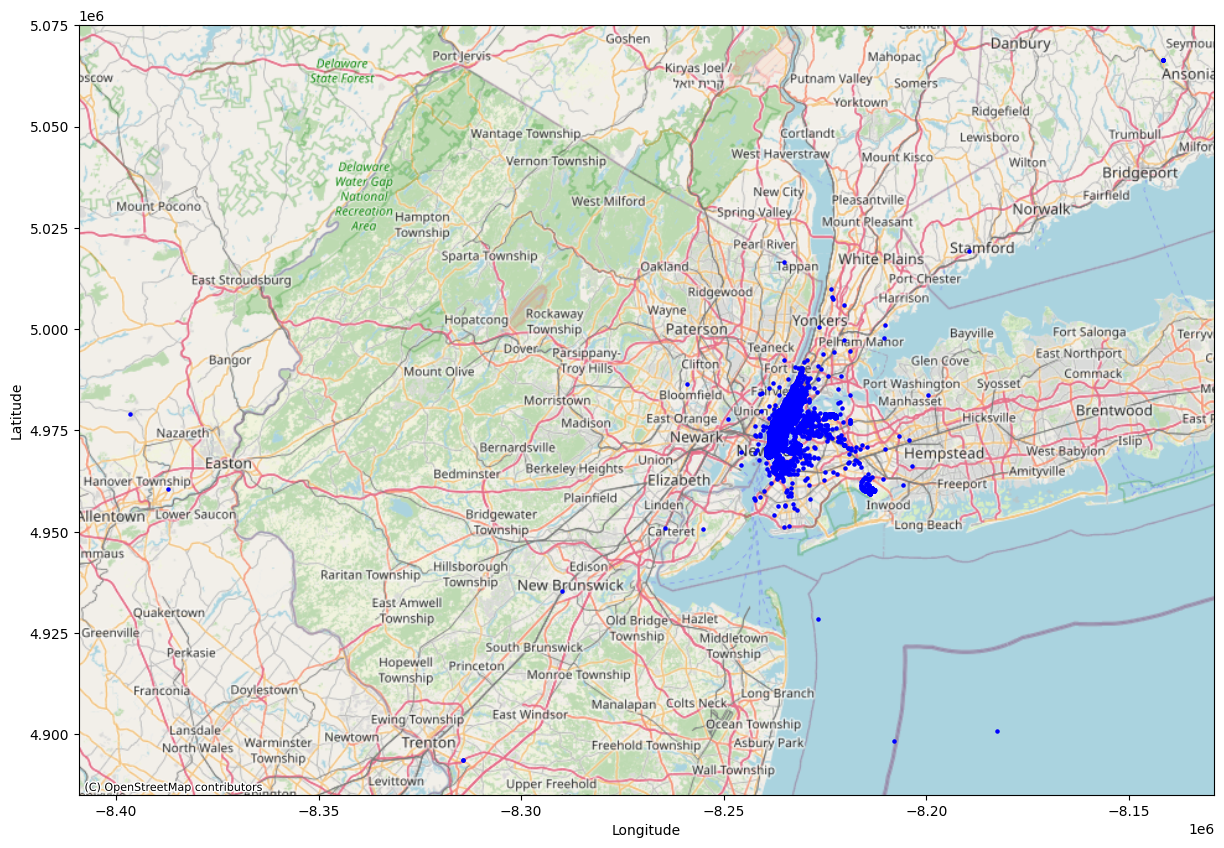

In [ ]:
#used chatgpt
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pickup_longitude, data.pickup_latitude))

# Set the coordinate reference system (CRS) to WGS84 (epsg:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert the data to Web Mercator for compatibility with contextily basemap
gdf = gdf.to_crs(epsg=3857)

# Now, let's plot the geospatial data on a 2D world graph
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the data
gdf.plot(ax=ax, color='blue', markersize=5)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Enable axis for context
ax.set_axis_on()

plt.show()

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/Weather_Data_NY.csv')

In [ ]:
weather_data.shape

(3287, 34)

In [ ]:
len(weather_data['datetime'][0])

10

In [ ]:
data = data.merge(weather_data[['datetime', 'icon']], left_on='date', right_on='datetime', how='left')

In [ ]:
data = data.drop(columns=['datetime'])
data = data.rename(columns={'icon': 'weather'})

In [ ]:
data = data[(data['pickup_latitude'].between(40.25, 41.2)) & (data['pickup_longitude'].between(-74.6, -73.3))]
data = data[(data['dropoff_latitude'].between(40.25, 41.2)) & (data['dropoff_longitude'].between(-74.6, -73.3))]
data = data.drop(['fare_amount', 'passenger_count',	'euclidean_distance', 'date',	'time',	'day_of_week',	'year',	'month',	'day',	'seconds'], axis = 1)
data['pickup_time'] = data['hour'] + data['minutes'] / 60
data = data.drop(['hour', 'minutes'], axis = 1)
data['distance'] = data['haversine_distance_km']
data = data.drop(['haversine_distance_km'], axis = 1)
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weather,pickup_time,distance
0,-73.999817,40.738354,-73.999512,40.723217,clear-day,19.866667,1.683323
1,-73.994355,40.728225,-73.994710,40.750325,rain,20.066667,2.457590
2,-74.005043,40.740770,-73.962565,40.772647,partly-cloudy-day,21.750000,5.036377
3,-73.976124,40.790844,-73.965316,40.803349,rain,8.366667,1.661683
4,-73.925023,40.744085,-73.973082,40.761247,rain,17.783333,4.475450


In [ ]:
data['weather'].value_counts()

partly-cloudy-day    11166
rain                  9459
clear-day             4516
snow                   742
cloudy                 323
fog                     13
wind                     7
Name: weather, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

encoder = OrdinalEncoder()

data['weather_encoded'] = encoder.fit_transform(data[['weather']])
data = data.drop('weather', axis=1)
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_time,distance,weather_encoded
0,-73.999817,40.738354,-73.999512,40.723217,19.866667,1.683323,0.0
1,-73.994355,40.728225,-73.994710,40.750325,20.066667,2.457590,4.0
2,-74.005043,40.740770,-73.962565,40.772647,21.750000,5.036377,3.0
3,-73.976124,40.790844,-73.965316,40.803349,8.366667,1.661683,4.0
4,-73.925023,40.744085,-73.973082,40.761247,17.783333,4.475450,4.0


In [ ]:
encoder.categories_

[array(['clear-day', 'cloudy', 'fog', 'partly-cloudy-day', 'rain', 'snow',
        'wind'], dtype=object)]

In [ ]:
data.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_latent_weather.csv')

## Performing the same operations on Data from 2016

In [ ]:
data_2016 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2016.csv')

In [ ]:
data_2016.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,date,time,day_of_week,haversine_distance_km,year,month,day,hour,minutes,seconds
0,3.754970,-73.993337,40.704640,-73.967160,40.692462,0.799407,0.028871,2016-10-08,1900-01-01 16:23:30,5,2.589152,2016,10,8,16,23,30
1,10.677653,-73.923804,40.753508,-74.011043,40.713760,1.024726,0.095868,2016-05-14,1900-01-01 12:23:01,5,8.577056,2016,5,14,12,23,1
2,28.195764,-73.958486,40.770873,-73.974856,40.780584,0.391605,0.019034,2016-06-04,1900-01-01 21:14:46,5,1.751027,2016,6,4,21,14,46
3,3.973048,-74.014006,40.765441,-73.991878,40.789847,0.747790,0.032944,2016-11-28,1900-01-01 12:11:34,0,3.291935,2016,11,28,12,11,34
4,18.820961,-74.018694,40.778900,-73.979031,40.734620,-0.066548,0.059446,2016-06-30,1900-01-01 23:16:37,3,5.950097,2016,6,30,23,16,37


In [ ]:
data_2016.shape

(1000, 17)

In [ ]:
data_2016 = data_2016.merge(weather_data[['datetime', 'icon']], left_on='date', right_on='datetime', how='left')

In [ ]:
data_2016.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,date,time,day_of_week,haversine_distance_km,year,month,day,hour,minutes,seconds,datetime,icon
0,3.754970,-73.993337,40.704640,-73.967160,40.692462,0.799407,0.028871,2016-10-08,1900-01-01 16:23:30,5,2.589152,2016,10,8,16,23,30,2016-10-08,rain
1,10.677653,-73.923804,40.753508,-74.011043,40.713760,1.024726,0.095868,2016-05-14,1900-01-01 12:23:01,5,8.577056,2016,5,14,12,23,1,2016-05-14,partly-cloudy-day
2,28.195764,-73.958486,40.770873,-73.974856,40.780584,0.391605,0.019034,2016-06-04,1900-01-01 21:14:46,5,1.751027,2016,6,4,21,14,46,2016-06-04,rain
3,3.973048,-74.014006,40.765441,-73.991878,40.789847,0.747790,0.032944,2016-11-28,1900-01-01 12:11:34,0,3.291935,2016,11,28,12,11,34,2016-11-28,clear-day
4,18.820961,-74.018694,40.778900,-73.979031,40.734620,-0.066548,0.059446,2016-06-30,1900-01-01 23:16:37,3,5.950097,2016,6,30,23,16,37,2016-06-30,clear-day


In [ ]:
data_2016 = data_2016.drop(columns=['datetime'])
data_2016 = data_2016.rename(columns={'icon': 'weather'})

In [ ]:
data_2016.shape

(1000, 18)

In [ ]:
data_2016 = data_2016[(data_2016['pickup_latitude'].between(40.25, 41.2)) & (data_2016['pickup_longitude'].between(-74.6, -73.3))]
data_2016 = data_2016[(data_2016['dropoff_latitude'].between(40.25, 41.2)) & (data_2016['dropoff_longitude'].between(-74.6, -73.3))]
data_2016 = data_2016.drop(['fare_amount', 'passenger_count',	'euclidean_distance', 'date',	'time',	'day_of_week',	'year',	'month',	'day',	'seconds'], axis = 1)
data_2016['pickup_time'] = data_2016['hour'] + data_2016['minutes'] / 60
data_2016 = data_2016.drop(['hour', 'minutes'], axis = 1)
data_2016['distance'] = data_2016['haversine_distance_km']
data_2016 = data_2016.drop(['haversine_distance_km'], axis = 1)
data_2016.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weather,pickup_time,distance
0,-73.993337,40.704640,-73.967160,40.692462,rain,16.383333,2.589152
1,-73.923804,40.753508,-74.011043,40.713760,partly-cloudy-day,12.383333,8.577056
2,-73.958486,40.770873,-73.974856,40.780584,rain,21.233333,1.751027
3,-74.014006,40.765441,-73.991878,40.789847,clear-day,12.183333,3.291935
4,-74.018694,40.778900,-73.979031,40.734620,clear-day,23.266667,5.950097


In [ ]:
data_2016['weather_encoded'] = encoder.transform(data_2016[['weather']])
data_2016 = data_2016.drop('weather', axis=1)
data_2016.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_time,distance,weather_encoded
0,-73.993337,40.704640,-73.967160,40.692462,16.383333,2.589152,4.0
1,-73.923804,40.753508,-74.011043,40.713760,12.383333,8.577056,3.0
2,-73.958486,40.770873,-73.974856,40.780584,21.233333,1.751027,4.0
3,-74.014006,40.765441,-73.991878,40.789847,12.183333,3.291935,0.0
4,-74.018694,40.778900,-73.979031,40.734620,23.266667,5.950097,0.0


In [ ]:
data_2016['weather_encoded'].value_counts()

3.0    465
4.0    398
0.0    115
5.0     16
1.0      6
Name: weather_encoded, dtype: int64

In [ ]:
data_2016.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_2016_latent_weather.csv')

## Performing the same operations on Data from 2017

In [ ]:
data_2017 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/synthetic_uber_data_2017.csv')

In [ ]:
data_2017.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,date,time,day_of_week,haversine_distance_km,year,month,day,hour,minutes,seconds
0,0.644374,-73.921559,40.759809,-73.962431,40.780003,2.676977,0.045588,2017-08-24,1900-01-01 02:01:34,3,4.109585,2017,8,24,2,1,34
1,21.837635,-73.998805,40.743252,-73.986864,40.716512,1.507802,0.029285,2017-03-10,1900-01-01 22:15:17,4,3.138967,2017,3,10,22,15,17
2,10.415688,-74.016647,40.818905,-73.986367,40.757258,-0.575934,0.068681,2017-03-04,1900-01-01 17:12:03,5,7.313422,2017,3,4,17,12,3
3,9.563742,-73.941280,40.769121,-74.054762,40.745237,1.145715,0.115969,2017-09-02,1900-01-01 02:25:52,5,9.920525,2017,9,2,2,25,52
4,8.389344,-73.995244,40.707357,-73.938367,40.754477,2.864139,0.073860,2017-06-18,1900-01-01 14:00:11,6,7.100758,2017,6,18,14,0,11


In [ ]:
data_2017 = data_2017.merge(weather_data[['datetime', 'icon']], left_on='date', right_on='datetime', how='left')

In [ ]:
data_2017 = data_2017.drop(columns=['datetime'])
data_2017 = data_2017.rename(columns={'icon': 'weather'})

In [ ]:
data_2017 = data_2017[(data_2017['pickup_latitude'].between(40.25, 41.2)) & (data_2017['pickup_longitude'].between(-74.6, -73.3))]
data_2017 = data_2017[(data_2017['dropoff_latitude'].between(40.25, 41.2)) & (data_2017['dropoff_longitude'].between(-74.6, -73.3))]
data_2017 = data_2017.drop(['fare_amount', 'passenger_count',	'euclidean_distance', 'date',	'time',	'day_of_week',	'year',	'month',	'day',	'seconds'], axis = 1)
data_2017['pickup_time'] = data_2017['hour'] + data_2017['minutes'] / 60
data_2017 = data_2017.drop(['hour', 'minutes'], axis = 1)
data_2017['distance'] = data_2017['haversine_distance_km']
data_2017 = data_2017.drop(['haversine_distance_km'], axis = 1)
data_2017.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weather,pickup_time,distance
0,-73.921559,40.759809,-73.962431,40.780003,rain,2.016667,4.109585
1,-73.998805,40.743252,-73.986864,40.716512,snow,22.250000,3.138967
2,-74.016647,40.818905,-73.986367,40.757258,rain,17.200000,7.313422
3,-73.941280,40.769121,-74.054762,40.745237,rain,2.416667,9.920525
4,-73.995244,40.707357,-73.938367,40.754477,partly-cloudy-day,14.000000,7.100758


In [ ]:
data_2017['weather_encoded'] = encoder.transform(data_2017[['weather']])
data_2017 = data_2017.drop('weather', axis=1)
data_2017.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_time,distance,weather_encoded
0,-73.921559,40.759809,-73.962431,40.780003,2.016667,4.109585,4.0
1,-73.998805,40.743252,-73.986864,40.716512,22.250000,3.138967,5.0
2,-74.016647,40.818905,-73.986367,40.757258,17.200000,7.313422,4.0
3,-73.941280,40.769121,-74.054762,40.745237,2.416667,9.920525,4.0
4,-73.995244,40.707357,-73.938367,40.754477,14.000000,7.100758,3.0


In [ ]:
data_2017.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_2017_latent_weather.csv')

##Assigning labels to data with Latent Variables

In [ ]:
import pandas as pd

nl_data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data.csv')
nl_data_2016 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2016.csv')
nl_data_2017 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2017.csv')

data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_latent_weather.csv')
data_2016 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_2016_latent_weather.csv')
data_2017 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/uber_data_2017_latent_weather.csv')

In [ ]:
# Drop the 'Unnamed: 0' column from both datasets
data.drop(columns=['Unnamed: 0'], inplace=True)
data_2016.drop(columns=['Unnamed: 0'], inplace=True)
data_2017.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
data['labels'] = nl_data['labels']
data_2016['labels'] = nl_data_2016['labels']
data_2017['labels'] = nl_data_2017['labels']

In [ ]:
data.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_latent.csv')

In [ ]:
data_2016.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2016_latent.csv')

In [ ]:
data_2017.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2017_latent.csv')

## Performing Data Amalgamation

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_latent.csv')

In [ ]:
data_2016 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2016_latent.csv')

In [ ]:
data_2017 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_2017_latent.csv')

In [ ]:
# Concatenate the datasets vertically
amalgamation1 = pd.concat([data_2016, data], ignore_index=True)

In [ ]:
amalgamation2 = pd.concat([data_2017, amalgamation1], ignore_index=True)

In [ ]:
amalgamation1.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/amalgamation1_latent.csv')

In [ ]:
amalgamation2.to_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/amalgamation2_latent.csv')

##MullerLoop

### Base Dataset

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/labeled_uber_data_latent.csv')

In [ ]:
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
#taken from Professor Ali Arsanjani's Github
# Modified from ...
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = data.drop('labels', axis = 1), data['labels']

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2, random_state=9)

# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
print('Results on the Base Dataset:')
print(90*'-' )
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(90*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Results on the Base Dataset:
------------------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 79.15, Training time = 0.67 seconds
Classifier = Linear SVM, Score (test, accuracy) = 75.64, Training time = 14.22 seconds
Classifier = RBF SVM, Score (test, accuracy) = 83.80, Training time = 14.31 seconds
Classifier = Decision Tree, Score (test, accuracy) = 82.73, Training time = 0.10 seconds
Classifier = Random Forest, Score (test, accuracy) = 80.56, Training time = 0.14 seconds
Classifier = Neural Net, Score (test, accuracy) = 82.73, Training time = 4.74 seconds
Classifier = AdaBoost, Score (test, accuracy) = 83.93, Training time = 1.36 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 70.82, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 65.82, Training time = 0.02 seconds
------------------------------------------------------------------------------------------
Best --> Cl

Accuracy: 83.93%
F1 Score: 0.78
Precision: 0.78
Recall: 0.78


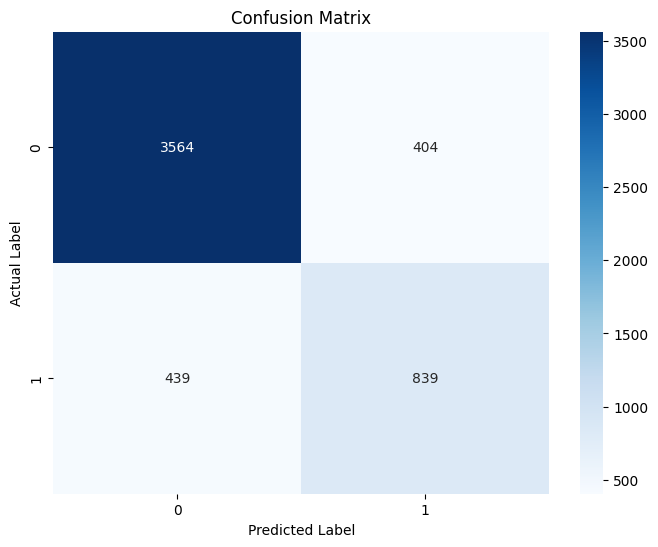

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_recall_curve
import seaborn as sns

# Assuming clf_best is the best classifier and using dummy variables for X_test, y_test
# Let's generate some dummy predictions using clf_best
# These lines would be replaced with actual predictions from the best classifier
y_pred = clf_best.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate F1 score, precision, and recall
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Displaying calculated metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {report["macro avg"]["f1-score"]:.2f}')
print(f'Precision: {report["macro avg"]["precision"]:.2f}')
print(f'Recall: {report["macro avg"]["recall"]:.2f}')

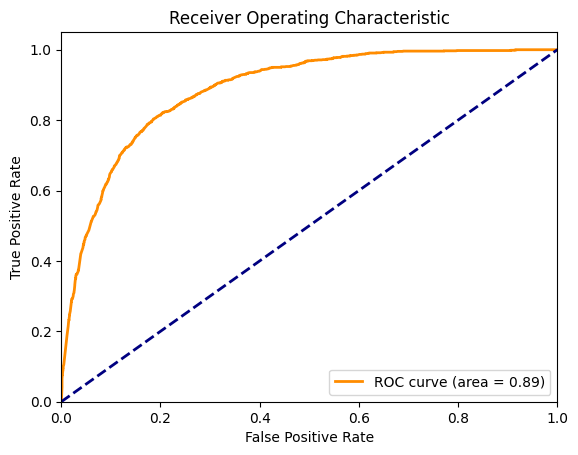

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming clf_best has a decision_function method
# Get decision scores
y_scores = clf_best.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

###On Dataset after 1 Amalgamation

In [ ]:
import pandas as pd
amalgamation1 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/amalgamation1_latent.csv')

In [ ]:
amalgamation1 = amalgamation1.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
amalgamation1.dropna()

In [ ]:
#taken from Professor Ali Arsanjani's Github
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = amalgamation1.drop('labels', axis = 1), amalgamation1['labels']

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2, random_state=9)

# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
print('Results on the Amalgamation1 Dataset:')
print(90*'-' )
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(90*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Results on the Amalgamation1 Dataset:
------------------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 79.16, Training time = 0.43 seconds
Classifier = Linear SVM, Score (test, accuracy) = 76.13, Training time = 11.17 seconds
Classifier = RBF SVM, Score (test, accuracy) = 83.38, Training time = 25.47 seconds
Classifier = Decision Tree, Score (test, accuracy) = 82.21, Training time = 0.10 seconds
Classifier = Random Forest, Score (test, accuracy) = 82.15, Training time = 0.15 seconds
Classifier = Neural Net, Score (test, accuracy) = 82.52, Training time = 5.48 seconds
Classifier = AdaBoost, Score (test, accuracy) = 83.44, Training time = 1.40 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 68.47, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 63.44, Training time = 0.01 seconds
------------------------------------------------------------------------------------------
Be

Accuracy: 83.44%
F1 Score: 0.77
Precision: 0.77
Recall: 0.76


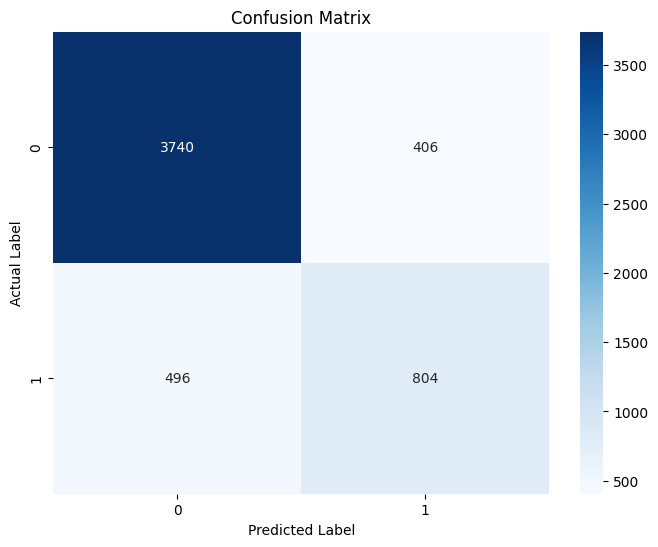

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_recall_curve
import seaborn as sns

# Assuming clf_best is the best classifier and using dummy variables for X_test, y_test
# Let's generate some dummy predictions using clf_best
# These lines would be replaced with actual predictions from the best classifier
y_pred = clf_best.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate F1 score, precision, and recall
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Displaying calculated metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {report["macro avg"]["f1-score"]:.2f}')
print(f'Precision: {report["macro avg"]["precision"]:.2f}')
print(f'Recall: {report["macro avg"]["recall"]:.2f}')

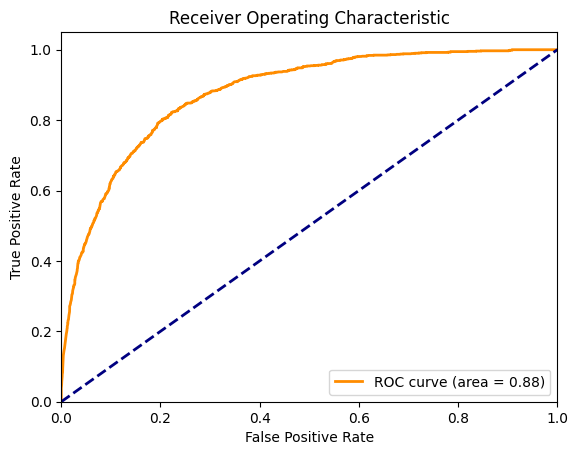

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming clf_best has a decision_function method
# Get decision scores
y_scores = clf_best.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

###On Dataset after 2 Amalgamation

In [ ]:
import pandas as pd
amalgamation2 = pd.read_csv('/content/drive/MyDrive/ML-Spring-2024/team-Pi/Data/amalgamation2_latent.csv')

In [ ]:
amalgamation2.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
amalgamation2.dropna()

In [ ]:
#taken from Professor Ali Arsanjani's Github
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = amalgamation2.drop('labels', axis = 1), amalgamation2['labels']

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2, random_state=9)

# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
print('Results on the Amalgamation2 Dataset:')
print(90*'-' )
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(90*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Results on the Amalgamation2 Dataset:
------------------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 78.29, Training time = 0.46 seconds
Classifier = Linear SVM, Score (test, accuracy) = 73.84, Training time = 10.93 seconds
Classifier = RBF SVM, Score (test, accuracy) = 83.05, Training time = 28.67 seconds
Classifier = Decision Tree, Score (test, accuracy) = 81.62, Training time = 0.10 seconds
Classifier = Random Forest, Score (test, accuracy) = 80.73, Training time = 0.15 seconds
Classifier = Neural Net, Score (test, accuracy) = 81.15, Training time = 5.28 seconds
Classifier = AdaBoost, Score (test, accuracy) = 82.62, Training time = 1.46 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 68.56, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 63.78, Training time = 0.01 seconds
------------------------------------------------------------------------------------------
Be

Accuracy: 83.05%
F1 Score: 0.77
Precision: 0.79
Recall: 0.75


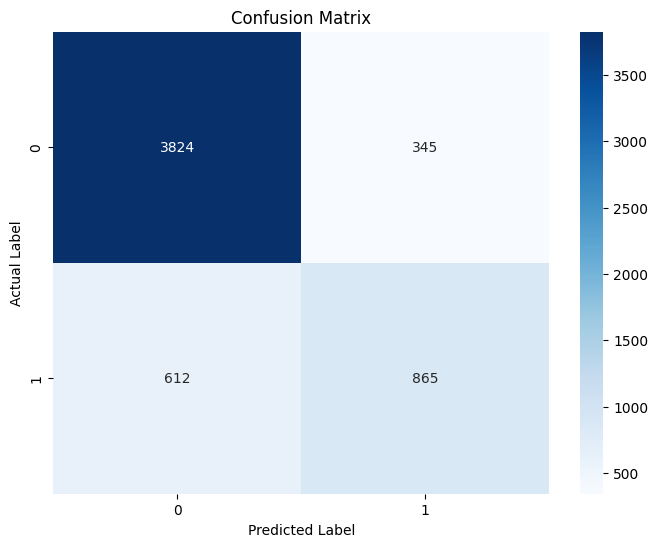

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score, precision_recall_curve
import seaborn as sns

# Assuming clf_best is the best classifier and using dummy variables for X_test, y_test
# Let's generate some dummy predictions using clf_best
# These lines would be replaced with actual predictions from the best classifier
y_pred = clf_best.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate F1 score, precision, and recall
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Displaying calculated metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {report["macro avg"]["f1-score"]:.2f}')
print(f'Precision: {report["macro avg"]["precision"]:.2f}')
print(f'Recall: {report["macro avg"]["recall"]:.2f}')

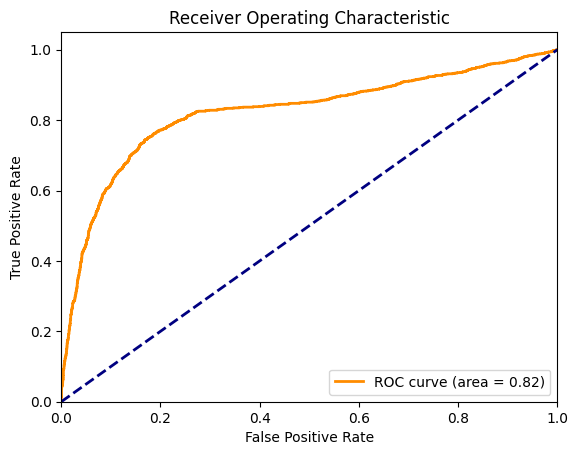

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming clf_best has a decision_function method
# Get decision scores
y_scores = clf_best.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##Results

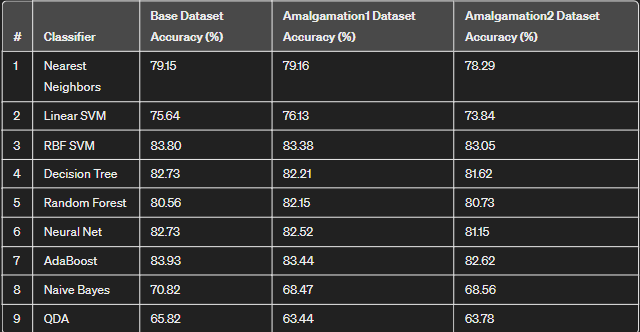